# Multilayer Perceptron: predicting if the expression of a target gene in a given cell is greater than its mean expression across all cells.

#### Features are expressions of other genes for each cell, where the set of other genes is either (1) genes considered first-degree neighbors in the StringDB gene network graph (2) all genes except target gene (3) a set of random genes of size N, where N is the number of first-degree neighbors the gene has in the StringDB gene network graph.

#### If StringDB is a "good" graph, the first-degree neighbors should provide as much or more information than all the genes

#### This analysis shows, as expected, that we are able to classify with high accuracy using an MLP. This is an initial step a regression problem, which can ultimately used for imputation of single-cell data.

#### Date: March 23, 2020
#### Author: Aarthi

In [4]:
import sys
sys.path += ['..']
import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.mlp import MLP
from models.gcn import GCN
from data import datasets
from data.gene_graphs import StringDBGraph
from data.utils import record_result, mouse_ensg_to_symbol

from sklearn.model_selection import train_test_split

import networkx as nx
import seaborn as sns

In [ ]:
# run to make above modules reload as they are editted
# sometimes doesn't work ? have to restart kernel
%load_ext autoreload
%autoreload 2

### Get expression data and PHATE embeddings

In [ ]:
pd.read_pickle("../data/joshi_processing/week8_ln_notebook_state.pkl")

### Load dataset

In [6]:
dataset = datasets.GeneDataset(name="Week_8_LN",
                   expr_path='/home/aarthivenkat/gene-graph-conv/data/datastore/week8_ln_magic_expr.csv')

In [7]:
dataset.load_data()

In [8]:
# Convert expression values to scaled to mean = 0 for each gene.
# Define task as predicting if expression value for a gene is greater than mean expression across all cells

dataset.df = dataset.df - dataset.df.mean(axis=0)
label_df = dataset.df.where(dataset.df > 0).notnull().astype("int")

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


### Load gene network graph

In [9]:
# Load StringDB graph
# Could use other gene network graphs but StringDB performed the best in previous papers
G = StringDBGraph()

 loading from cache file/home/aarthivenkat/gene-graph-conv/data/graphs/stringdb_mouse_graph_all_edges.adjlist


In [10]:
G.nx_graph.number_of_nodes()

20755

In [11]:
# Intersection between graph and dataset nodes encompasses 52% of graph nodes and 91% of dataset nodes

print ('Graph node coverage : %.2f' % (len(set(G.nx_graph.nodes())&set(dataset.df.columns))/(len(G.nx_graph.nodes())*1.0)*100))
print ('Dataset node coverage : %.2f' % (len(set(G.nx_graph.nodes())&set(dataset.df.columns))/(dataset.df.shape[1]*1.0)*100))

Graph node coverage : 53.08
Dataset node coverage : 90.93


### Dicts for mapping Ensembl and Gene Symbol

In [12]:
gene_symbol = mouse_ensg_to_symbol(datastore="../data") # ensembl to symbol
ensembl = dict((v,k) for k,v in gene_symbol.items()) # symbol to ensembl

### Train and Test MLP Function

In [13]:
def train_test_model(df, labels, gene, G, train_size, test_size, use_first_degree, n=10, cuda=False, random=False, use_GCN=False):
    seed = 123
    if not use_GCN:
        model = MLP(name="MLP", column_names=dataset.df.columns, dropout=False, cuda=cuda)
    else:
        model = GCN(name="GCN_lay4_chan32_emb32_dropout", cuda=True, num_layer=4, channels=32, embedding=32, dropout=True)

    results = []    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(df, labels, \
                                                      stratify=labels, \
                                                      train_size=train_size, \
                                                      test_size=test_size)
        if use_first_degree:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            X_train = X_train.loc[:, neighbors].copy()
            X_test = X_test.loc[:, neighbors].copy()
            genes = neighbors
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph.subgraph(neighbors).copy())
        elif random:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            random_genes = np.random.choice(df.columns, len(neighbors)-1) 
            X_train = X_train.loc[:, random_genes].copy()
            X_test = X_test.loc[:, random_genes].copy()
            genes = random_genes
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph.subgraph(random_genes).copy())
        else:
            X_train = X_train.copy()
            X_test = X_test.copy()
            genes = []
            if use_GCN:
                adj = nx.adjacency_matrix(G.nx_graph)

        try:
            X_train[gene] = 1
            X_test[gene] = 1
            
            # X_train.drop(gene, axis=1, inplace=True)
            # X_test.drop(gene, axis=1, inplace=True)
        except:
            pass

        try:
            if not use_GCN:
                model.fit(X_train, y_train)
            else:
                model.fit(X_train, y_train, adj=adj)
            # x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
            if cuda:
                x_test = x_test.cuda()
            # y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
            y_hat = model.predict(X_test)[:, 1].data.cpu().numpy()
            auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

            results.append(auc)
        except Exception as e:
            print (e)
            
    return results, [X_test, y_hat, y_test]

### Three marker genes of interest in dataset
#### Cd8a should be highly expressed throughout, Sell should be highly expressed in one population and lowly expressed in another population, Foxp3 should be lowly expressed throughout

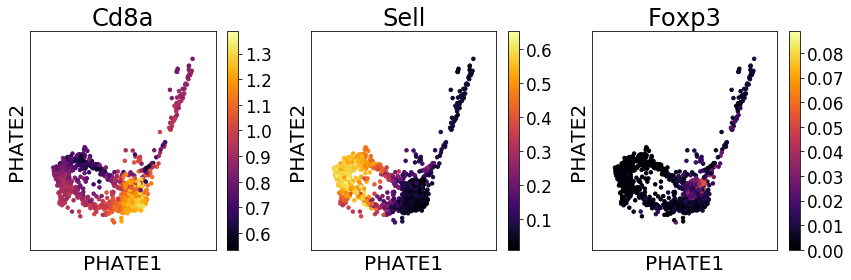

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc, ax=axes[0],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Cd8a"), title="Cd8a",
                     ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[1],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Sell"), title="Sell",
                     ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[2],fontsize=14, s=12, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word="Foxp3"), title="Foxp3",
                     ticks=False, label_prefix="PHATE")

plt.tight_layout()

### Visualize distribution of expression across cells for each gene

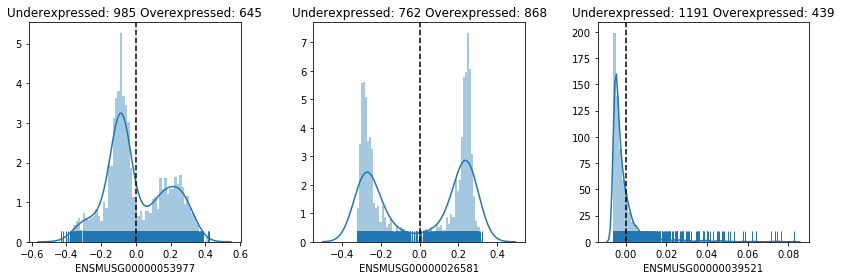

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(dataset.df[ensembl['Cd8a']], rug=True, bins=60, ax=axes[0])
axes[0].axvline(x=0, c='black', linestyle='--')
axes[0].set_title("Underexpressed: {} Overexpressed: {}".format(label_df[ensembl['Cd8a']].value_counts()[0],
                                                               label_df[ensembl['Cd8a']].value_counts()[1]))

sns.distplot(dataset.df[ensembl['Sell']], rug=True, bins=60, ax=axes[1])
axes[1].axvline(x=0, c='black', linestyle='--')
axes[1].set_title("Underexpressed: {} Overexpressed: {}".format(label_df[ensembl['Sell']].value_counts()[0],
                                                               label_df[ensembl['Sell']].value_counts()[1]))

sns.distplot(dataset.df[ensembl['Foxp3']], rug=True, bins=60, ax=axes[2])
axes[2].axvline(x=0, c='black', linestyle='--')
axes[2].set_title("Underexpressed: {} Overexpressed: {}".format(label_df[ensembl['Foxp3']].value_counts()[0],
                                                               label_df[ensembl['Foxp3']].value_counts()[1]))


plt.tight_layout()

### Train for Cd8a with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [15]:
gene = ensembl['Cd8a']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [25]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Cd8a
Number of first neighbors in graph 443
Number of first neighbors in graph and found in dataset 308


In [58]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!


### AUC results for Cd8a

In [22]:
print('AUC (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('AUC (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('AUC (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

AUC (first degree): 0.996 +/- 0.001
AUC (all genes): 0.998 +/- 0.001
AUC (random genes): 0.996 +/- 0.001


### Visualizing Prediction for Test Data

In [67]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [71]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

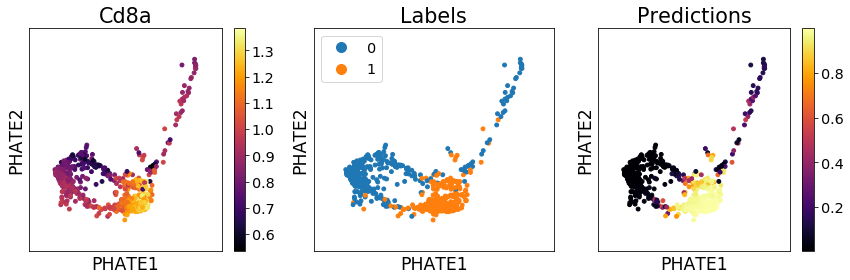

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

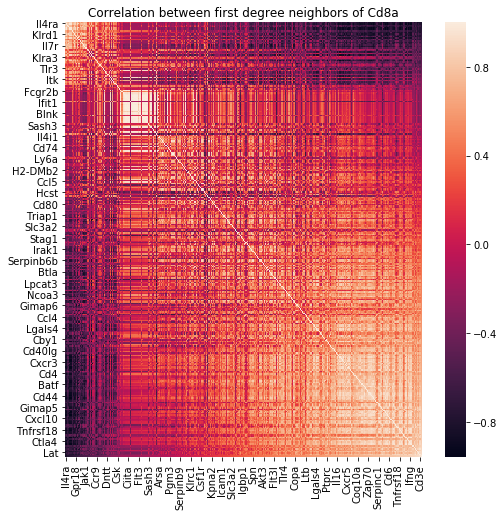

In [27]:
# Computing the correlation between the first degree neighbors of the chosen gene
dat = dataset.df[neighbors]
plt.figure(figsize=(8,8))
tmp = dat.corr().sort_values(gene)
tmp = tmp.loc[:,tmp.index]
tmp.columns = tmp.index = [gene_symbol[gene] for gene in list(tmp.columns) if gene in gene_symbol]
ax = sns.heatmap(tmp)
plt.title('Correlation between first degree neighbors of %s' % gene_symbol[gene])
plt.show()

### Train for Sell with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [82]:
gene = ensembl['Sell']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [83]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Sell
Number of first neighbors in graph 1296
Number of first neighbors in graph and found in dataset 821


In [88]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!


### AUC results for Sell

In [85]:
print('AUC (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('AUC (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('AUC (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

AUC (first degree): 0.999 +/- 0.000
AUC (all genes): 0.998 +/- 0.001
AUC (random genes): 0.995 +/- 0.001


### Visualizing Prediction for Test Data

In [89]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [90]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

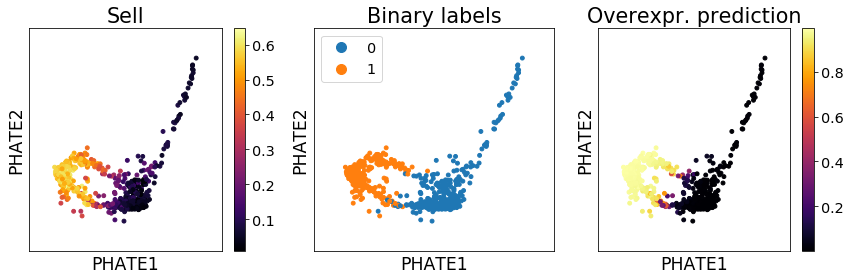

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

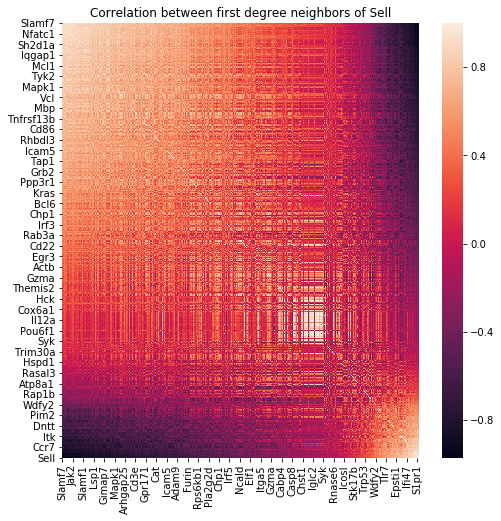

In [32]:
# Computing the correlation between the first degree neighbors of the chosen gene
dat = dataset.df[neighbors]
plt.figure(figsize=(8,8))
tmp = dat.corr().sort_values(gene)
tmp = tmp.loc[:,tmp.index]
tmp.columns = tmp.index = [gene_symbol[gene] for gene in list(tmp.columns) if gene in gene_symbol]
ax = sns.heatmap(tmp)
plt.title('Correlation between first degree neighbors of %s' % gene_symbol[gene])
plt.show()

### Train for Foxp3 with only first-degree neighbors, all other genes, and N random genes
#### N = number of first-degree neighbors

In [92]:
gene = ensembl['Foxp3']
dataset.labels = label_df[gene]
train_size = 0.5
test_size = 0.5

#### Number of first-degree neighbors

In [93]:
print ('Gene:', gene_symbol[gene])
neighbors = list(G.first_degree(gene)[0])
print ('Number of first neighbors in graph', len(neighbors))
neighbors = list(set(neighbors) & set(dataset.df.columns))
print ('Number of first neighbors in graph and found in dataset', len(neighbors))

Gene: Foxp3
Number of first neighbors in graph 1636
Number of first neighbors in graph and found in dataset 1076


In [94]:
firstdeg_results, firstdeg_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                             train_size, test_size, use_first_degree=True)

fc_results, fc_test = train_test_model(dataset.df, dataset.labels, gene, G,
                              train_size, test_size, use_first_degree=False)

random_results, random_test = train_test_model(dataset.df, dataset.labels, gene, G, 
                              train_size, test_size, use_first_degree=False, random=True)

INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!
INFO:root:Constructing the network...
INFO:root:Done!


### AUC results for Foxp3

In [36]:
print('AUC (first degree): %.3f +/- %.3f' %(np.mean(firstdeg_results), np.std(firstdeg_results)))
print('AUC (all genes): %.3f +/- %.3f' %(np.mean(fc_results), np.std(fc_results)))
print('AUC (random genes): %.3f +/- %.3f' %(np.mean(random_results), np.std(random_results)))

AUC (first degree): 0.934 +/- 0.010
AUC (all genes): 0.957 +/- 0.008
AUC (random genes): 0.933 +/- 0.008


### Visualizing Prediction for Test Data

In [95]:
firstdeg_test[0]['prediction'] = firstdeg_test[1]
firstdeg_test[0]['label'] = firstdeg_test[2]
firstdeg_test[0].sort_index(inplace=True)

In [96]:
test_mask = data_magic_filt.index.isin(firstdeg_test[0].index)

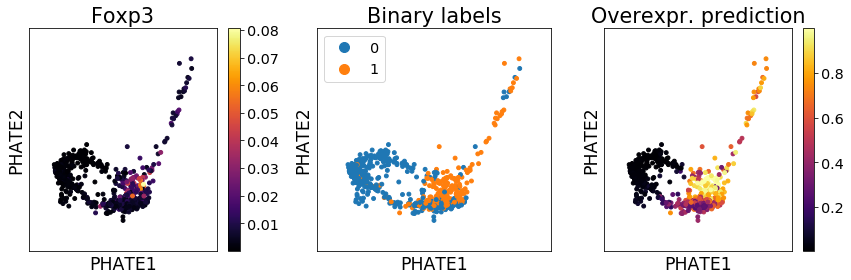

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[test_mask], exact_word=gene_symbol[gene]), 
                     title=gene_symbol[gene], ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=firstdeg_test[0]['label'], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=firstdeg_test[0]['prediction'], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

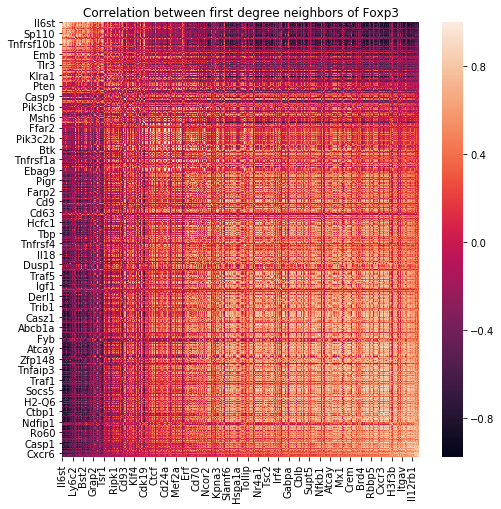

In [37]:
# Computing the correlation between the first degree neighbors of the chosen gene
dat = dataset.df[neighbors]
plt.figure(figsize=(8,8))
tmp = dat.corr().sort_values(gene)
tmp = tmp.loc[:,tmp.index]
tmp.columns = tmp.index = [gene_symbol[gene] for gene in list(tmp.columns) if gene in gene_symbol]
ax = sns.heatmap(tmp)

plt.title('Correlation between first degree neighbors of %s' % gene_symbol[gene])
plt.show()